In [19]:
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft
from scipy.signal import get_window, spectrogram
import pickle
import uproot

In [45]:
def make_plot(filename):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/'+filename,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']



    if filename=="LERFUJI_2024-10-16_08-57-48.npz":
        X_delta=np.zeros(len(X_sum))
    if filename=="LERFUJI_2024-10-15_19-08-53.npz":
        X_sum=np.zeros(len(X_delta))
    if filename=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))


    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, np.nan, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff'])
    df['result_interp']=df['result_diff'].interpolate(method='spline',order=1)

    condition = df['X_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['X_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除


    df=df.dropna()
    # 移動平均と移動標準偏差を計算
    df['result_ma500'] = df['result_diff'].rolling(window=500).mean()
    df['result_ma10000'] = df['result_diff'].rolling(window=10000).mean()
    # window=500の移動平均を17行下にシフト
    df['result_ma500_shifted'] = df['result_ma500'].shift(17)
    # 二つの移動平均の差の絶対値を計算
    df['result_ma_diff'] = abs(df['result_ma500_shifted'] - df['result_ma10000'])
    df['result_std500'] = df['result_diff'].rolling(window=500).std()
    df['std_shifted']=df['result_std500'].shift(500)

    condition = df['result_ma_diff'] > df['std_shifted']*0.5
    first_row = df[condition].head(1)
    # その行のColumn3の値を取得
    exceed_x=0
    if not first_row.empty:
        exceed_x = first_row['x'].values[0]

    if len(df)==0:
        return 
    df['x']=df['x']-df['x'].iloc[-1]

    abort_x = df.loc[(df['result_ma_diff'] > df['std_shifted']).idxmax(), 'x']
    
    fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True,figsize=(16,6))
    ax1.set_title(f'{filename}')
    ax1.scatter(df['x'],df['result_diff']*16.58/5,label='X Position',c='red',s=1)
    ax1.plot(df['x'], df['result_ma_diff']*20, label='MA')
    ax1.plot(df['x'], df['std_shifted']*20, label='STD')
    ax1.vlines(abort_x,ymin=-0.4,ymax=0.4)
    ax1.set_ylim(-0.4,0.4)
    ax1.grid()
    ax1.set_ylabel('X position (mm)')
    ax1.legend()

    #############################

    df = pd.DataFrame({'x':timesteps2,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=4000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['Y_sum'] > threshold, df['Y_delta'] / df['Y_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.4, np.nan, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['Y_sum'] <= threshold, np.nan, df['result_diff'])
    df['result_interp']=df['result_diff'].interpolate(method='spline',order=1)

    #-------------------
    df=df.dropna()
    # 移動平均と移動標準偏差を計算
    df['result_ma500'] = df['result_diff'].rolling(window=500).mean()
    df['result_ma10000'] = df['result_diff'].rolling(window=10000).mean()
    # window=500の移動平均を17行下にシフト
    df['result_ma500_shifted'] = df['result_ma500'].shift(17)
    # 二つの移動平均の差の絶対値を計算
    df['result_ma_diff'] = abs(df['result_ma500_shifted'] - df['result_ma10000'])
    df['result_std500'] = df['result_diff'].rolling(window=500).std()
    df['std_shifted']=df['result_std500'].shift(500)

    if len(df)==0:
        return

    df['x']=df['x']-df['x'].iloc[-1]
    abort_y = df.loc[(df['result_ma_diff'] > df['std_shifted']).idxmax(), 'x']

    ax2.scatter(df['x'],df['result_diff']*16.58/5,label='Y Position', c='red',s=1)
    ax2.plot(df['x'], df['result_ma_diff']*20, label='MA')
    ax2.plot(df['x'], df['std_shifted']*20, label='STD')
    ax2.vlines(abort_y,ymin=-0.4,ymax=0.4)

    ax2.grid()
    ax2.legend()
    ax2.set_ylim(-0.4,0.4)
    ax2.set_ylabel("Y position (mm)")

    ###############################
    #
    #     CLAWS
    #
    ###############################
    input_str=filename
    formatted_string = input_str[8:-4].replace('-', '')
    # 探すディレクトリのパス
    directory_path = './'
    # ディレクトリ内のファイルをチェックして、部分一致するものを探す
    for waveform_filepath in os.listdir(directory_path):
        if waveform_filepath[:-11]==formatted_string:
            print(f"Found matching file: {waveform_filepath}")
            with uproot.open(waveform_filepath) as data_file:
                data_file_items = data_file.items()
                data_file_items = list(reversed(data_file_items))
                ys=[]
                for ps_serial, ps_data in data_file_items:
                    y_keys = [k for k in ps_data.keys() if k != "t"]
                    x = ps_data["t"].array(library="np")
                    ys.append([ps_data[k].array(library="np") for k in y_keys])
                t0index=np.where((ys[0][1]/(-800)*100)>50)[0][0]
                t_shifted=(x-x[t0index]+4160-12300)/1000
                

    index = np.where((ys[0][3]+1870)/1870*150 > 50)[0]  
    first_exceed=0
    if len(index) > 0:
        first_exceed = t_shifted[index[0]]
        

    for y in ys[1]:
        ax3.plot(t_shifted, y)
    #ax3.plot(t_shifted,ys[0][1]/(-800)*100)
    ax3.plot(t_shifted,(ys[0][3]+1870)/1870*150)
    # 凡例とタイトルの設定
    #ax4.legend()
    ax3.set_ylim(-200,200)
    #ax3.set_xticks([-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0])
    ax3.grid()
    ax3.set_xlabel("Time (us)")
    ax3.text(0.02, 0.05, 'NLC CLAWS', transform=ax3.transAxes, ha='left', va='bottom', fontsize=10)


    plt.xlim(-100,0)
    ax3.set_xlabel("Time (us)")
    plt.savefig(f'picture/{filename[8:-4]}.png',dpi=100)
    plt.show()
    plt.close()

    return abort_x-first_exceed, abort_y-first_exceed


In [24]:
os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/')

['LERFUJI_2024-10-27_02-02-02.npz',
 'LERFUJI_2024-10-20_13-51-29.npz',
 'LERFUJI_2024-10-21_08-08-53.npz',
 'LERFUJI_2024-10-29_23-49-03.npz',
 'LERFUJI_2024-10-28_02-30-07.npz',
 'LERFUJI_2024-10-27_06-17-55.npz',
 'LERFUJI_2024-10-27_23-44-12.npz',
 'LERFUJI_2024-10-30_02-30-10.npz',
 'LERFUJI_2024-10-22_09-20-05.npz',
 'LERFUJI_2024-10-15_23-43-13.npz',
 'LERFUJI_2024-10-15_20-22-59.npz',
 'LERFUJI_2024-10-21_08-59-35.npz',
 'LERFUJI_2024-10-23_03-16-57.npz',
 'LERFUJI_2024-10-16_04-52-14.npz',
 'LERFUJI_2024-10-15_20-56-49.npz',
 'LERFUJI_2024-10-27_05-25-07.npz',
 'LERFUJI_2024-10-30_02-02-03.npz',
 'LERFUJI_2024-10-28_02-55-30.npz',
 'LERFUJI_2024-10-21_00-35-06.npz',
 'LERFUJI_2024-10-18_02-29-34.npz',
 'LERFUJI_2024-10-15_22-52-26.npz',
 'LERFUJI_2024-10-19_21-33-36.npz',
 'LERFUJI_2024-10-27_05-01-04.npz',
 'LERFUJI_2024-10-22_09-37-16.npz',
 'LERFUJI_2024-10-27_21-28-33.npz',
 'LERFUJI_2024-10-15_20-04-25.npz',
 'LERFUJI_2024-10-29_01-41-14.npz',
 'LERFUJI_2024-10-29_03-00-3

Found matching file: 20241027_065520435209.root


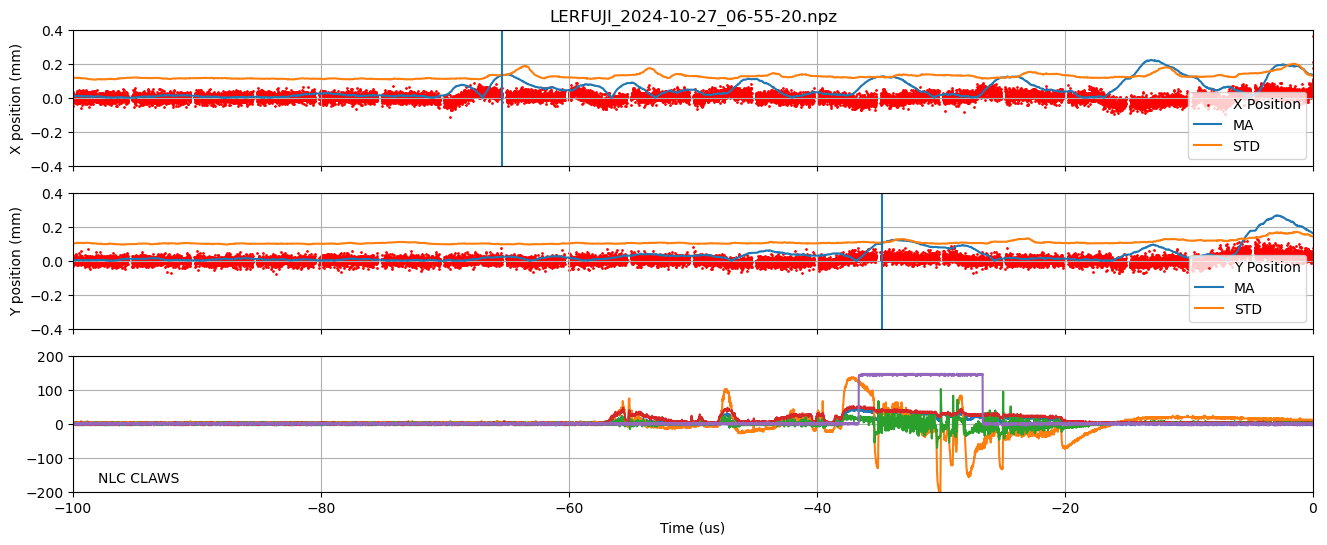

In [46]:
a,b=make_plot('LERFUJI_2024-10-27_06-55-20.npz')

Found matching file: 20241027_020202861543.root


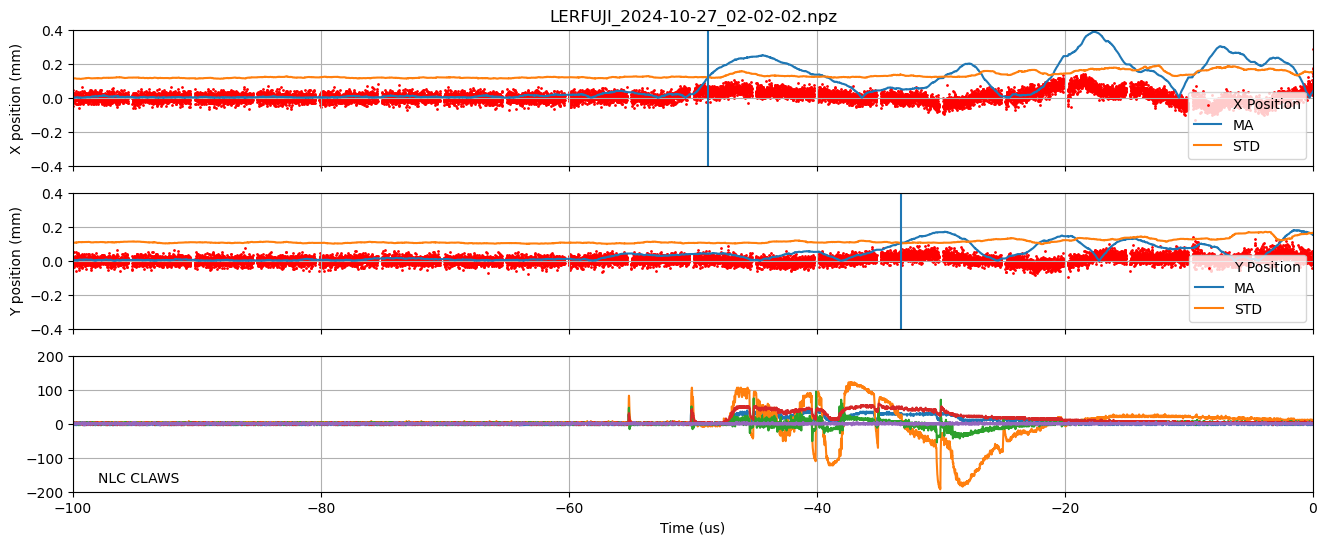

Found matching file: 20241020_135129525073.root


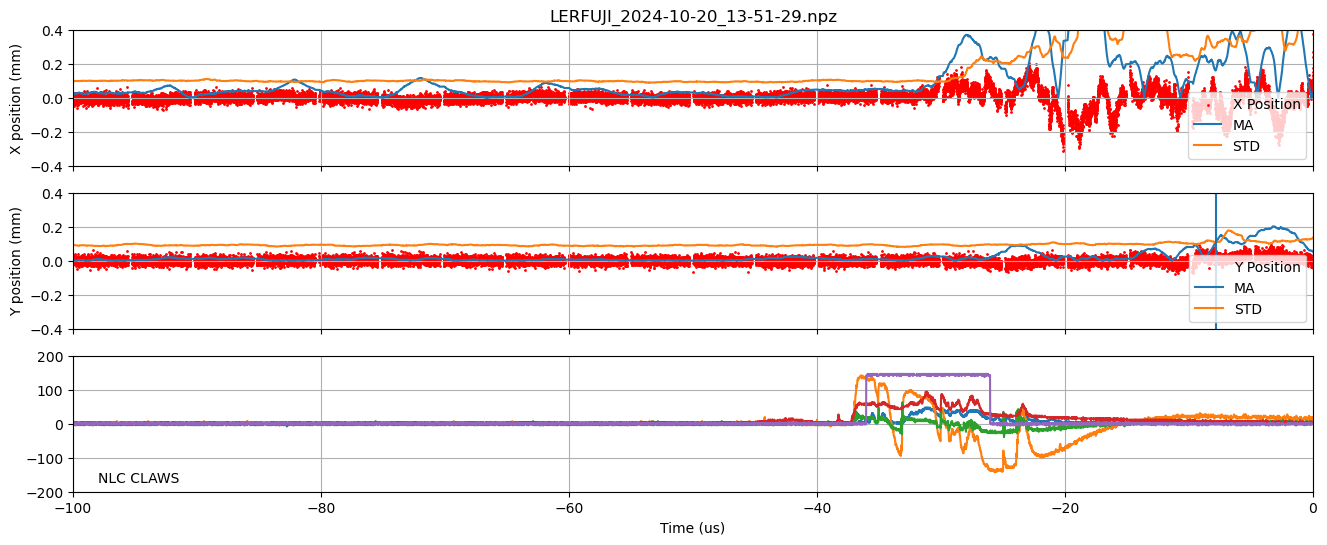

Found matching file: 20241021_080853241108.root


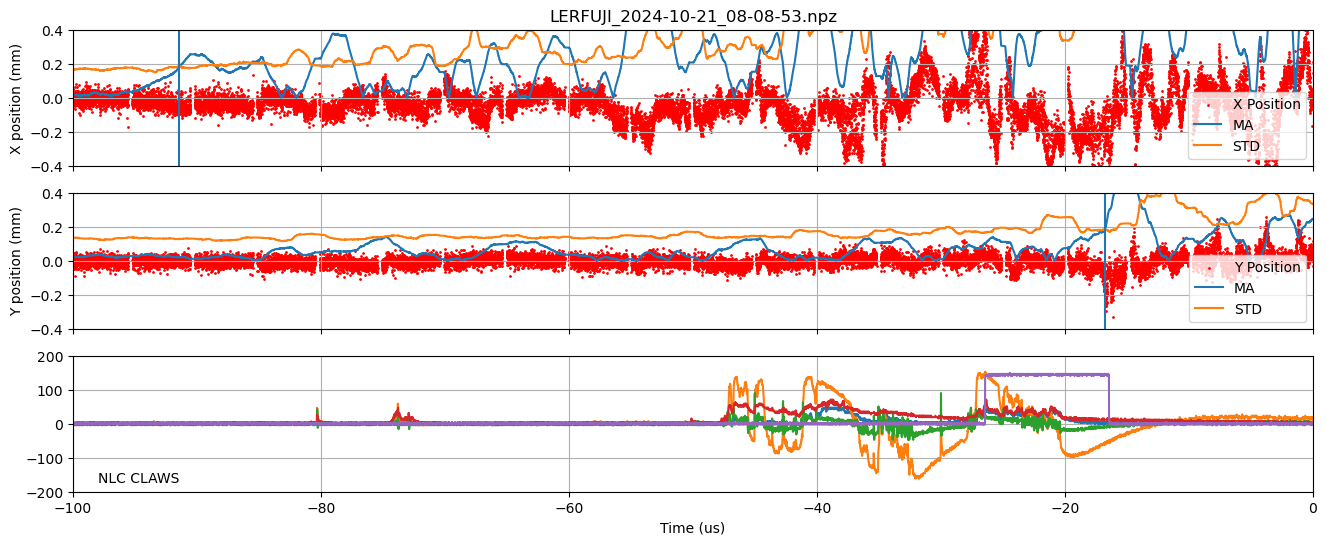

Found matching file: 20241029_234903352479.root


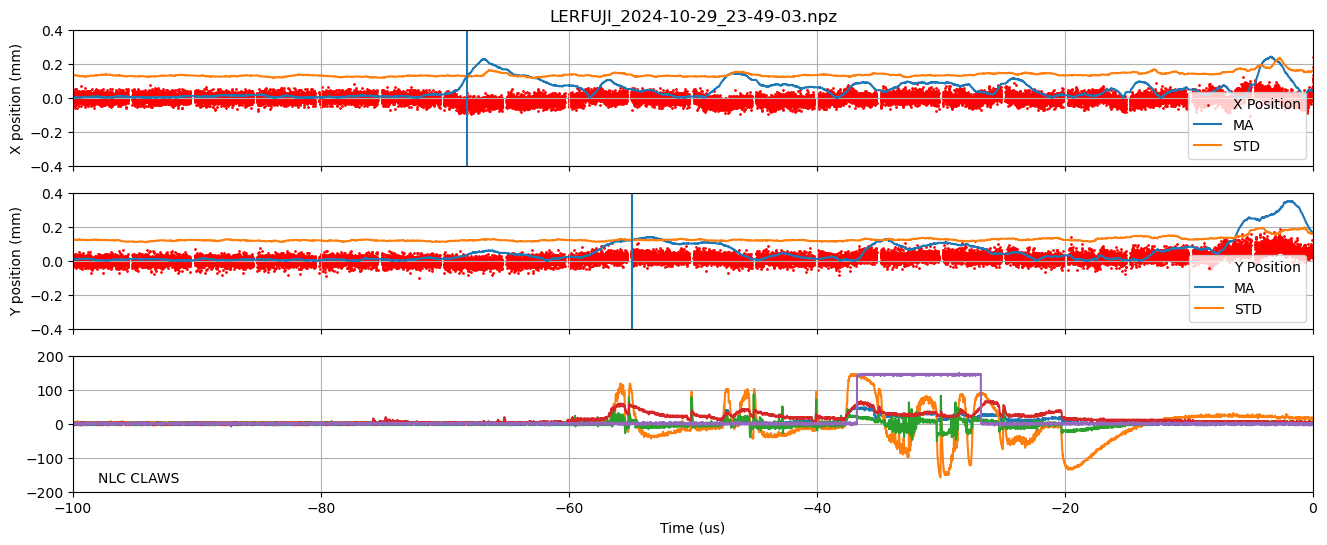

Found matching file: 20241028_023007926489.root


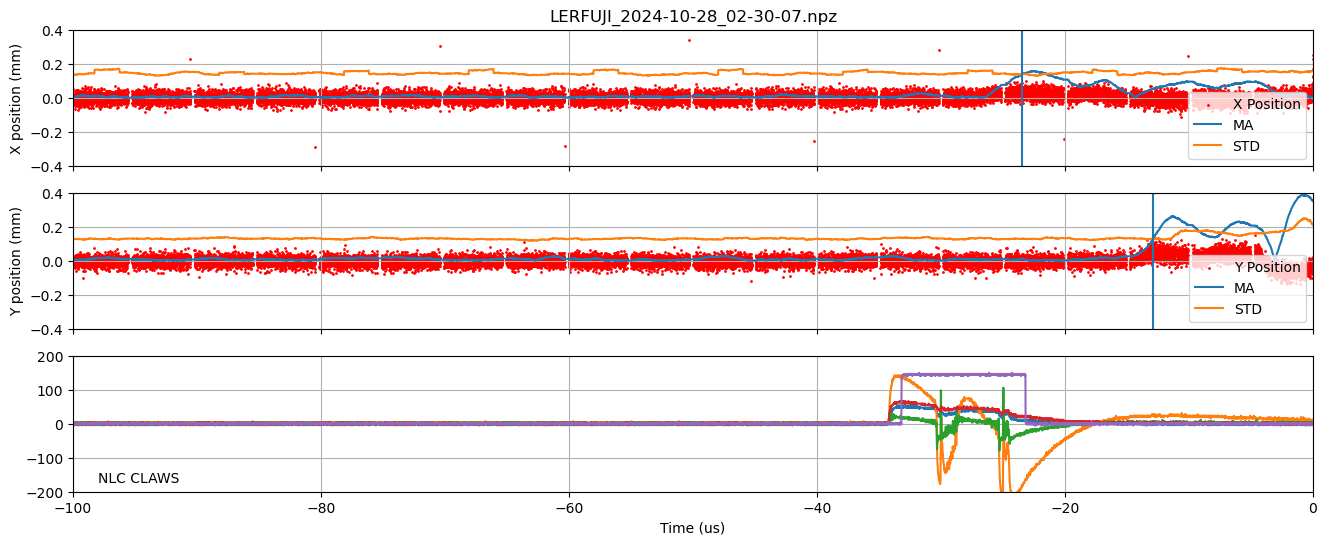

Found matching file: 20241027_061755773487.root


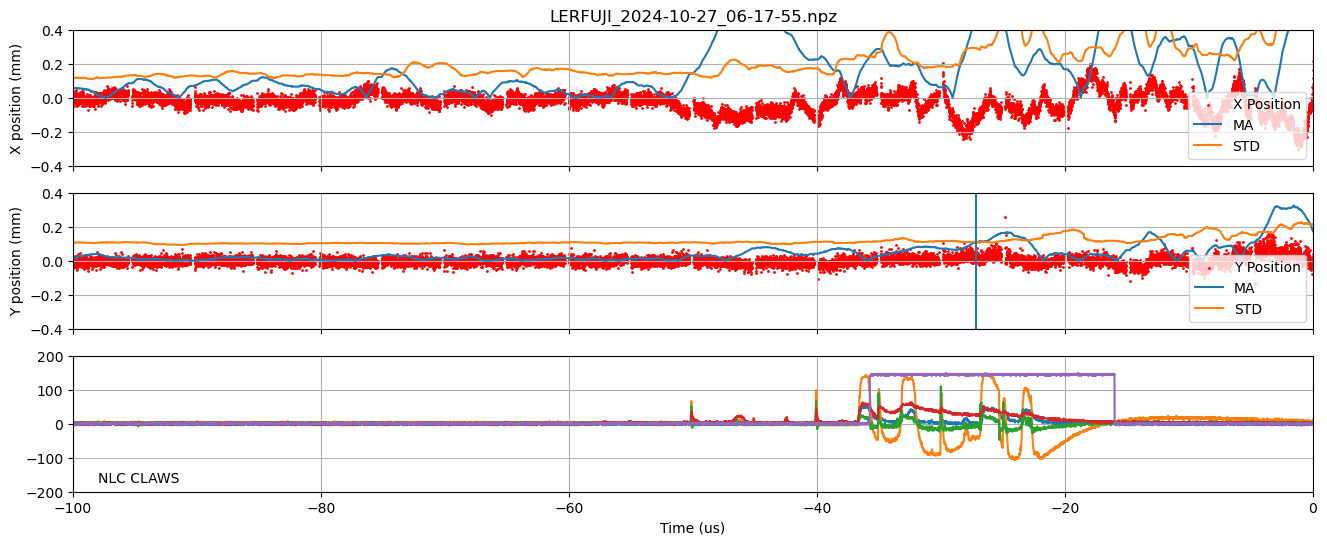

Found matching file: 20241027_234412512837.root


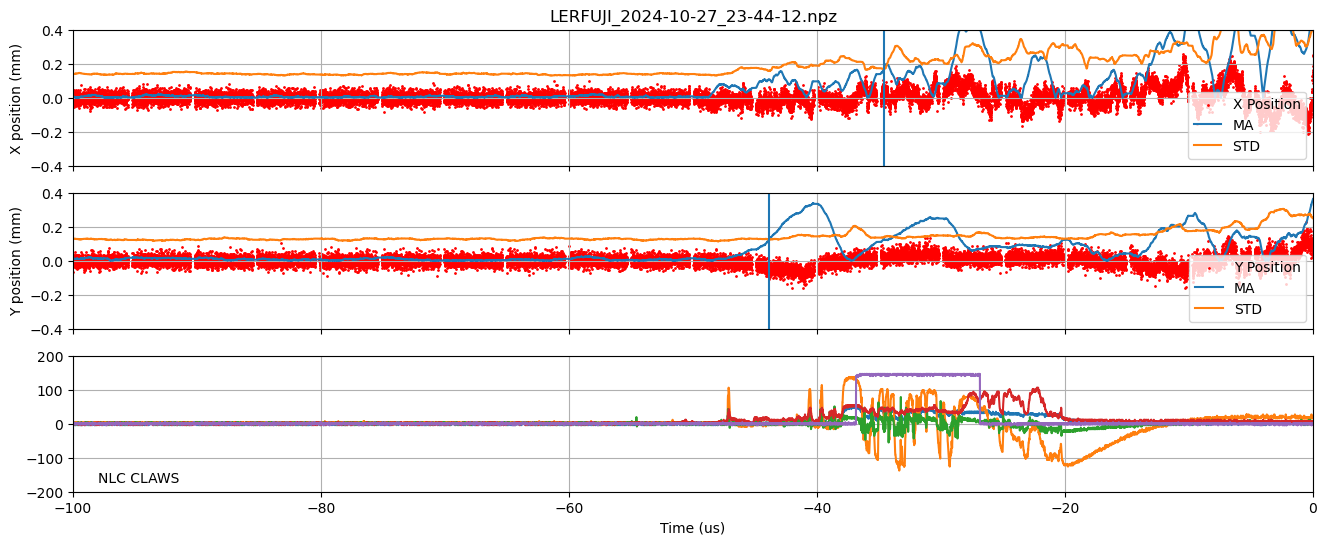

Found matching file: 20241030_023010507559.root


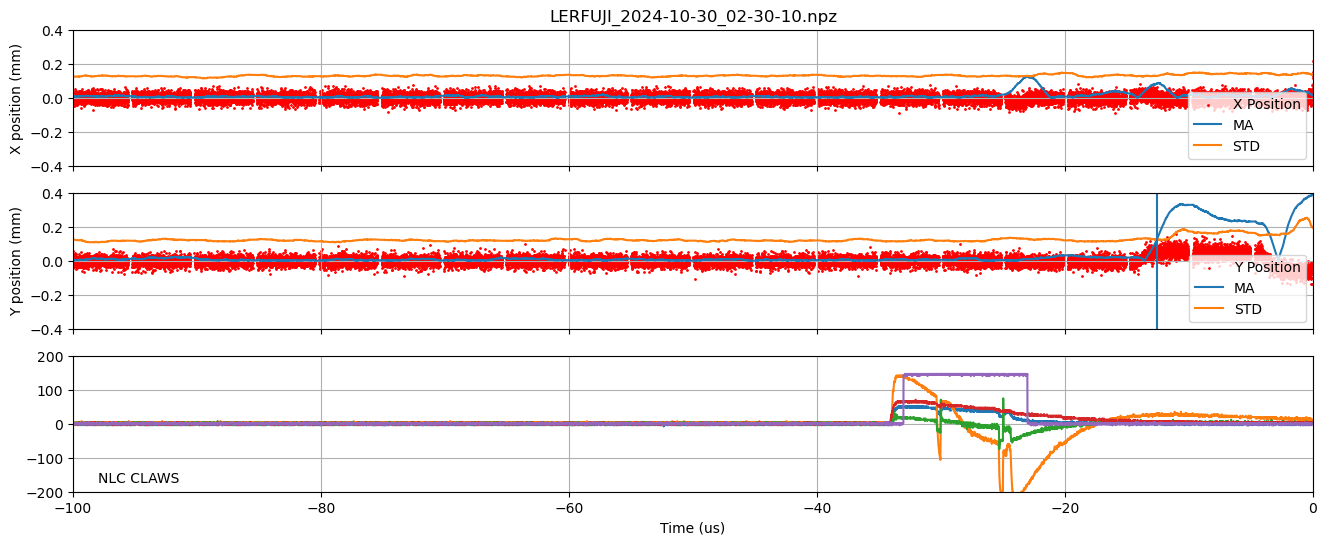

Found matching file: 20241022_092005521207.root


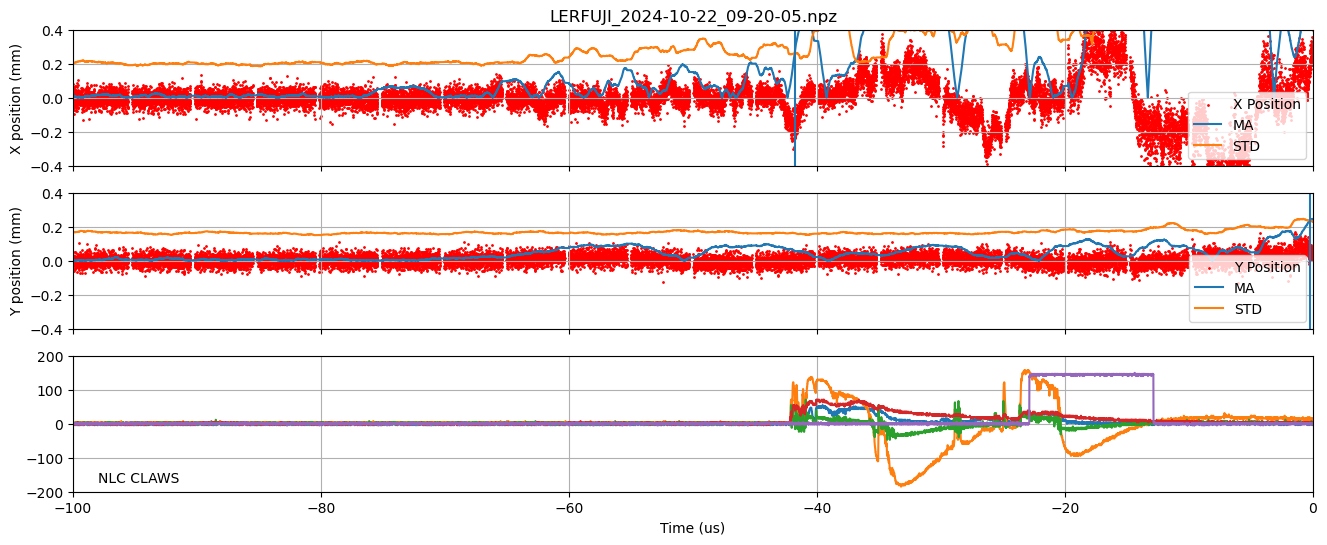

Found matching file: 20241015_234313765138.root


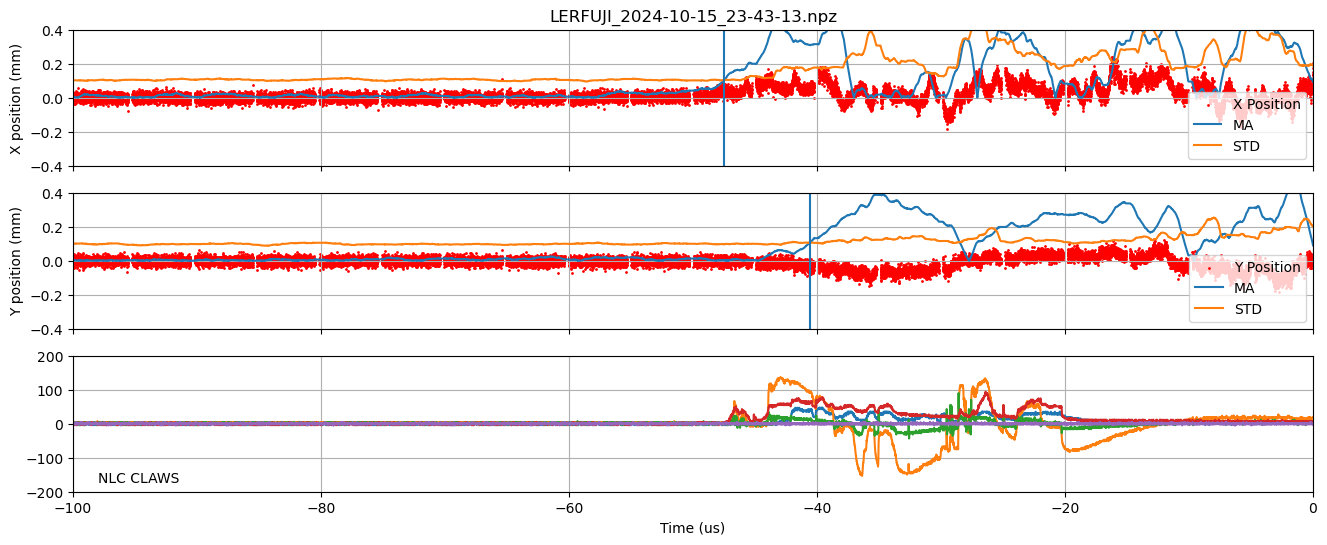

Found matching file: 20241015_202259600857.root


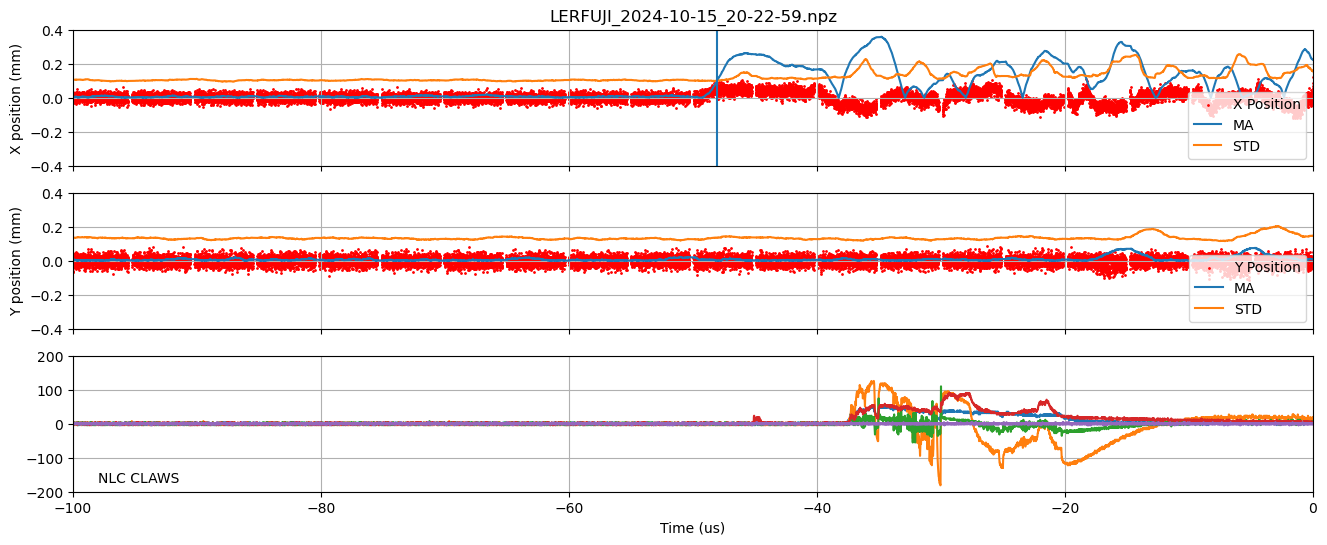

Found matching file: 20241021_085935153074.root


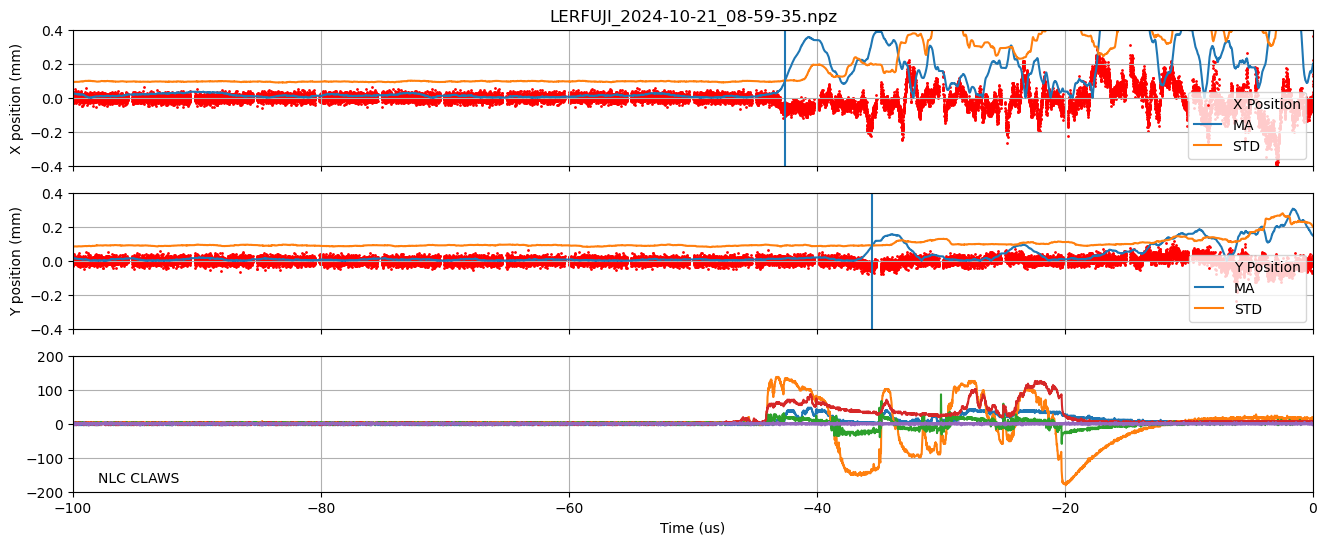

Found matching file: 20241023_031657210170.root


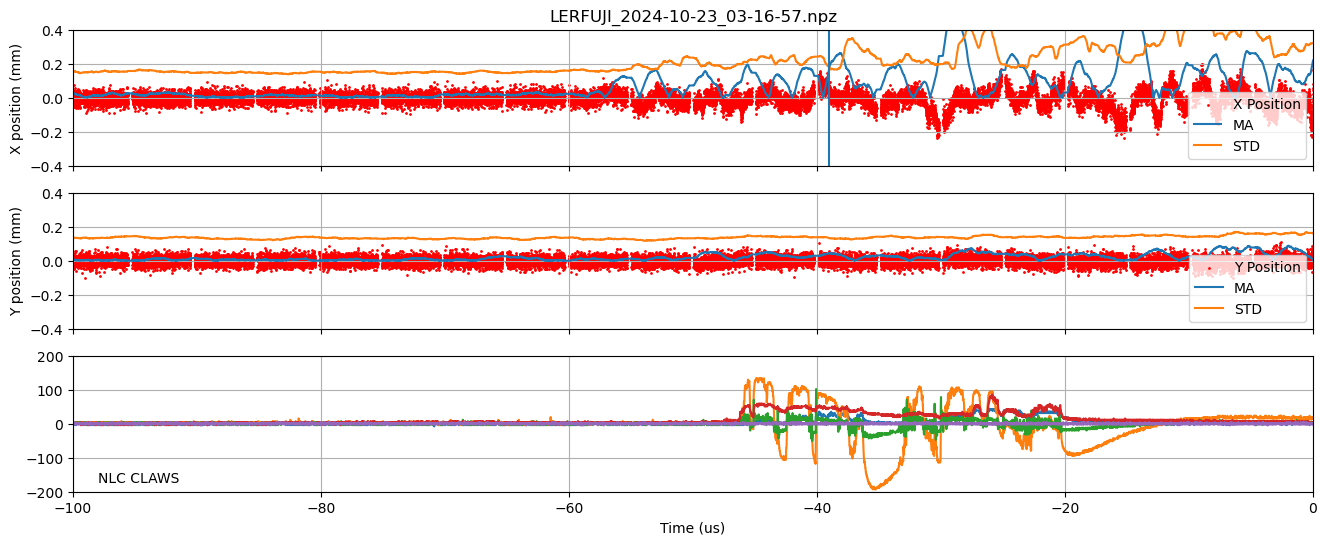

Found matching file: 20241016_045214638026.root


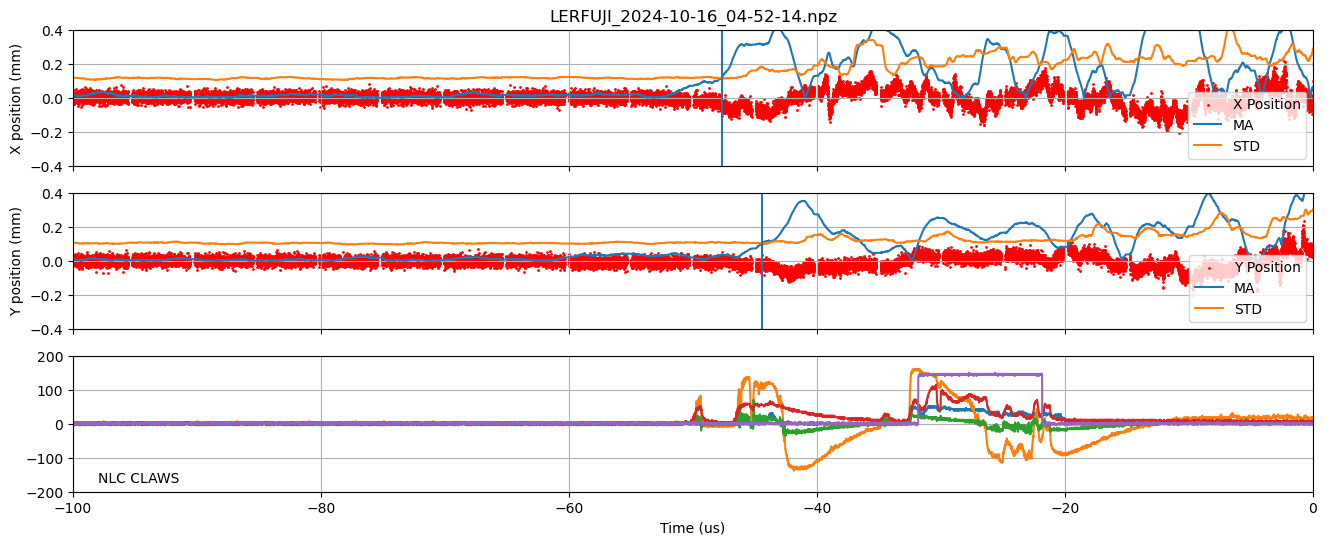

Found matching file: 20241015_205649855604.root


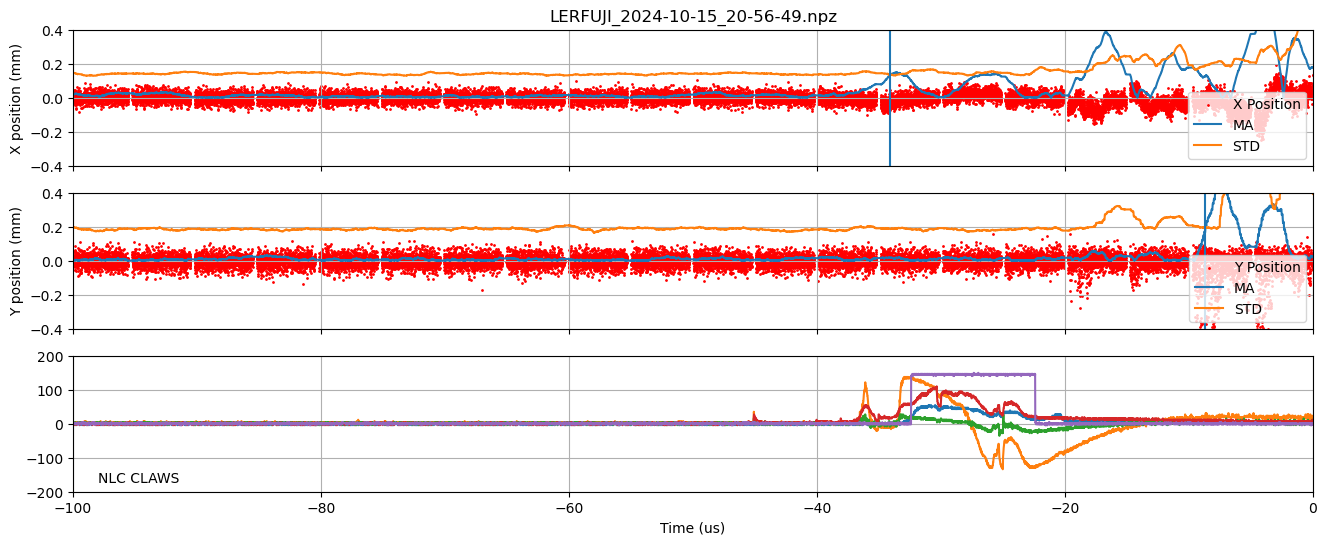

Found matching file: 20241027_052507980964.root


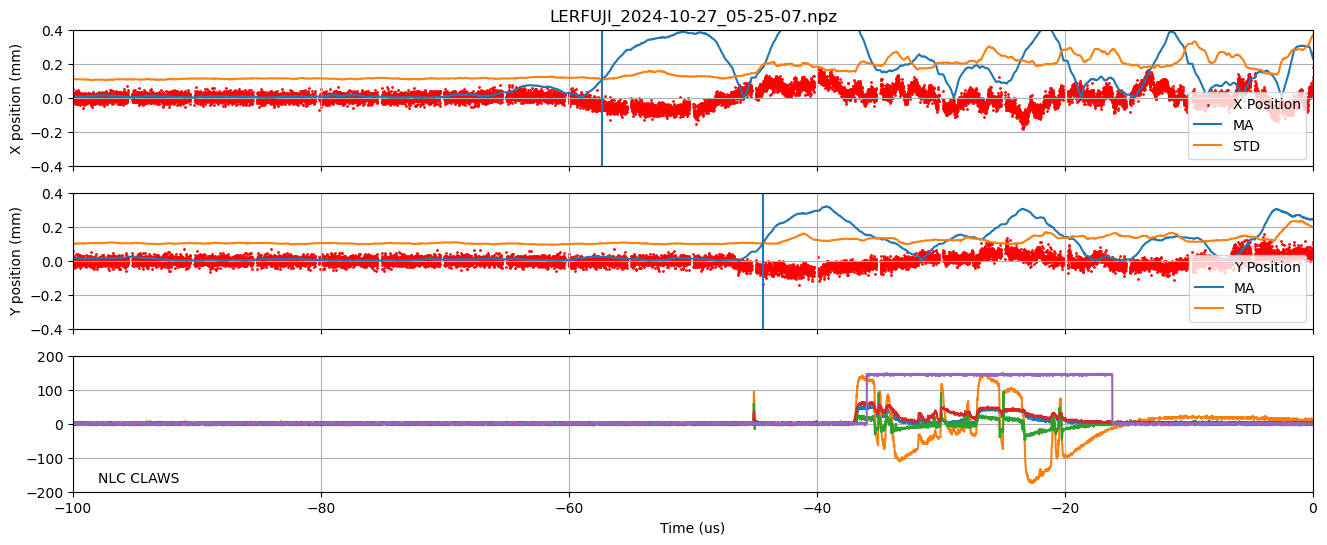

Found matching file: 20241030_020203955413.root


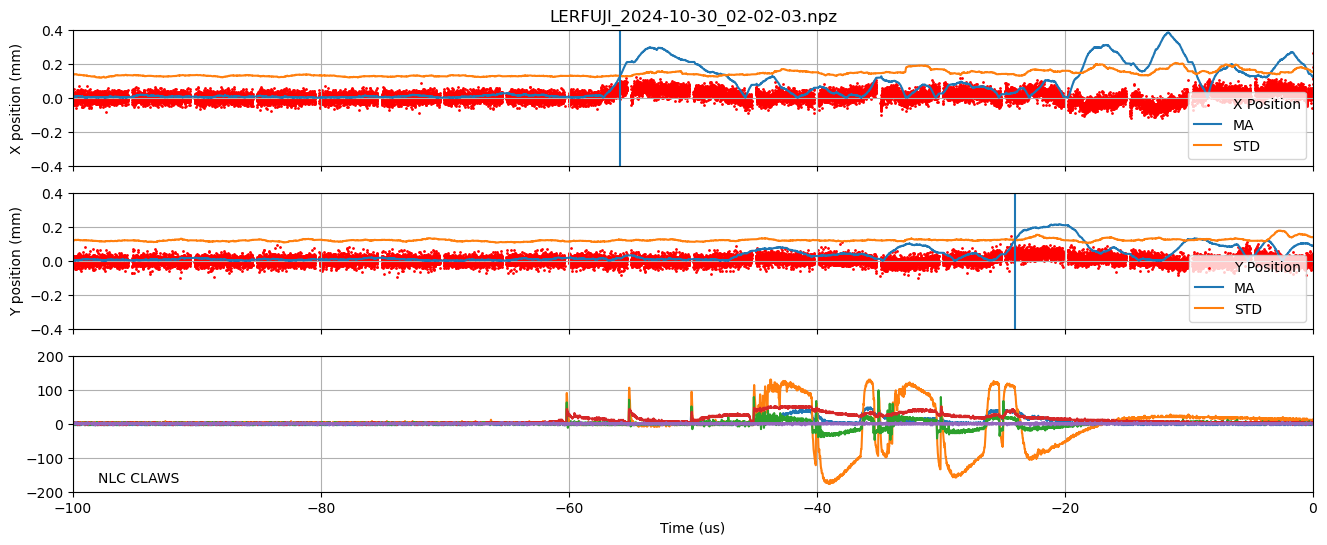

Found matching file: 20241028_025530510786.root


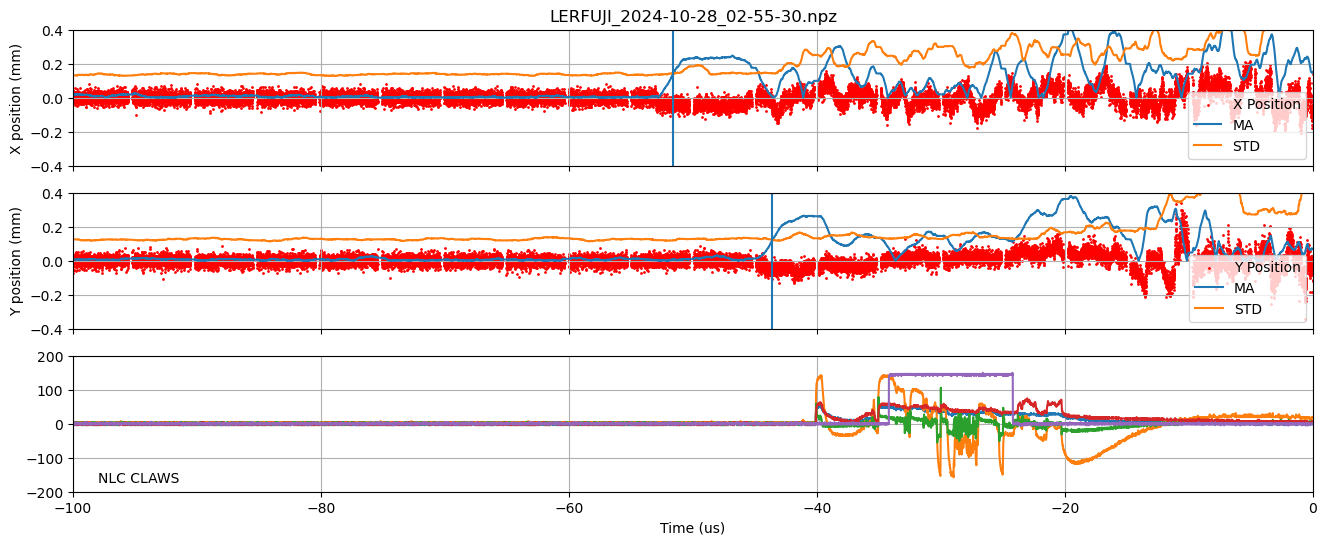

Found matching file: 20241021_003506009931.root


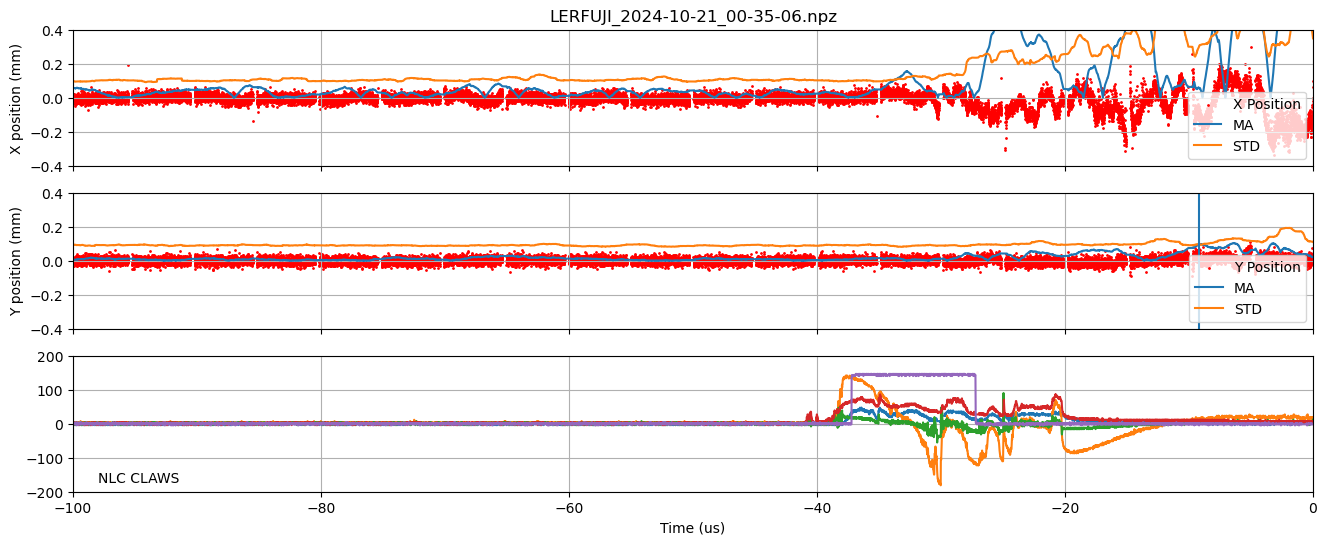

Found matching file: 20241018_022934928364.root


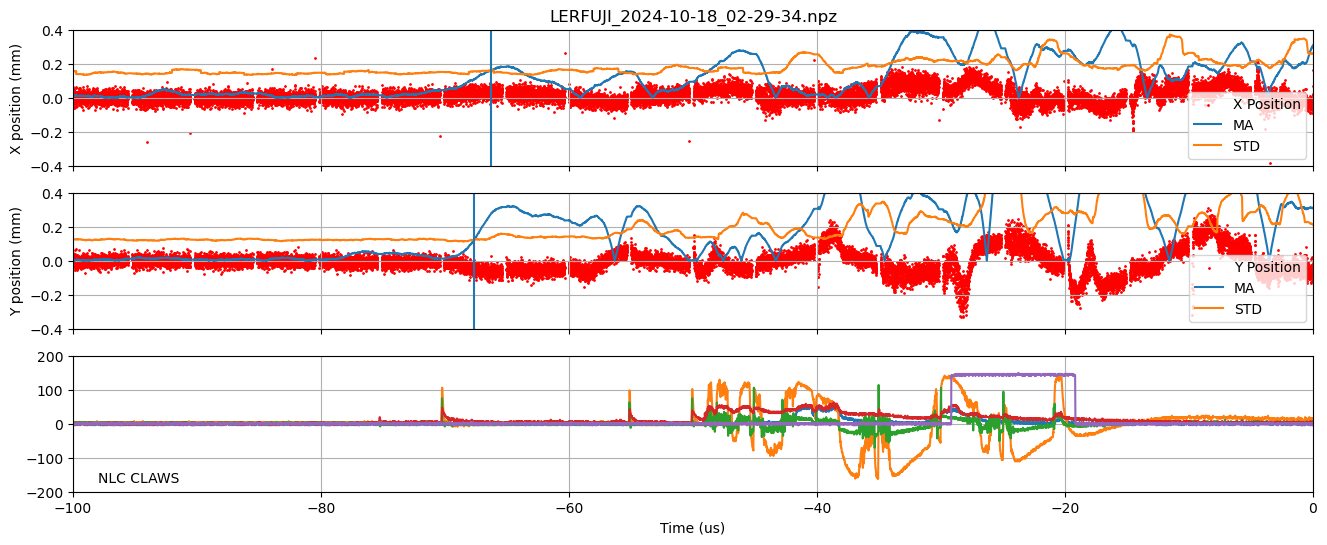

Found matching file: 20241015_225226590827.root


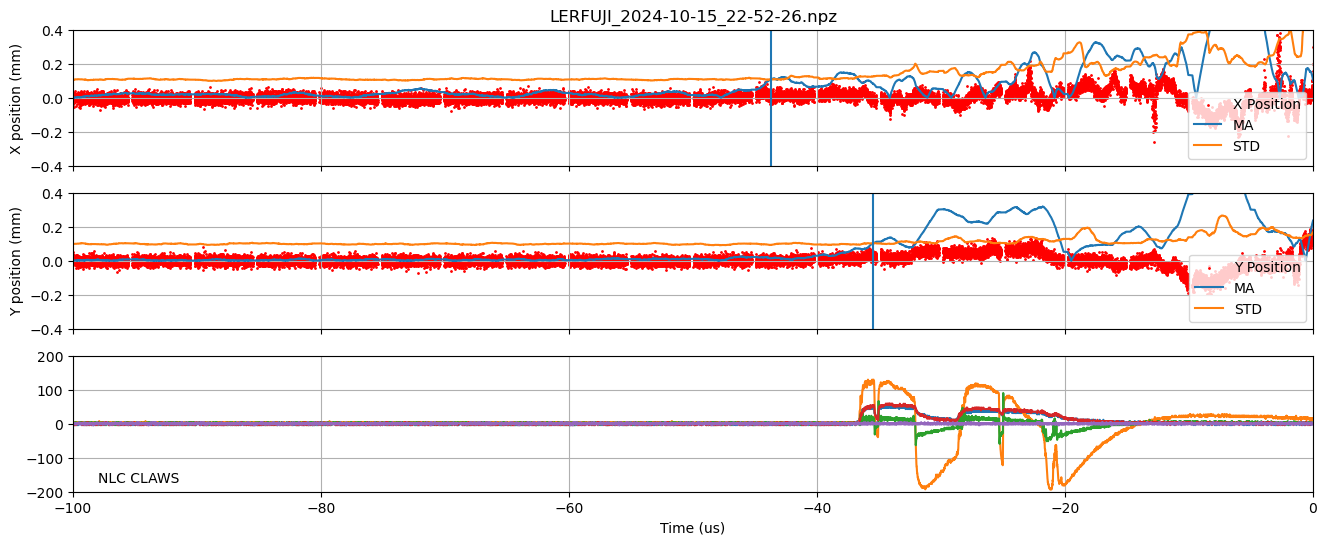

Found matching file: 20241019_213336092010.root


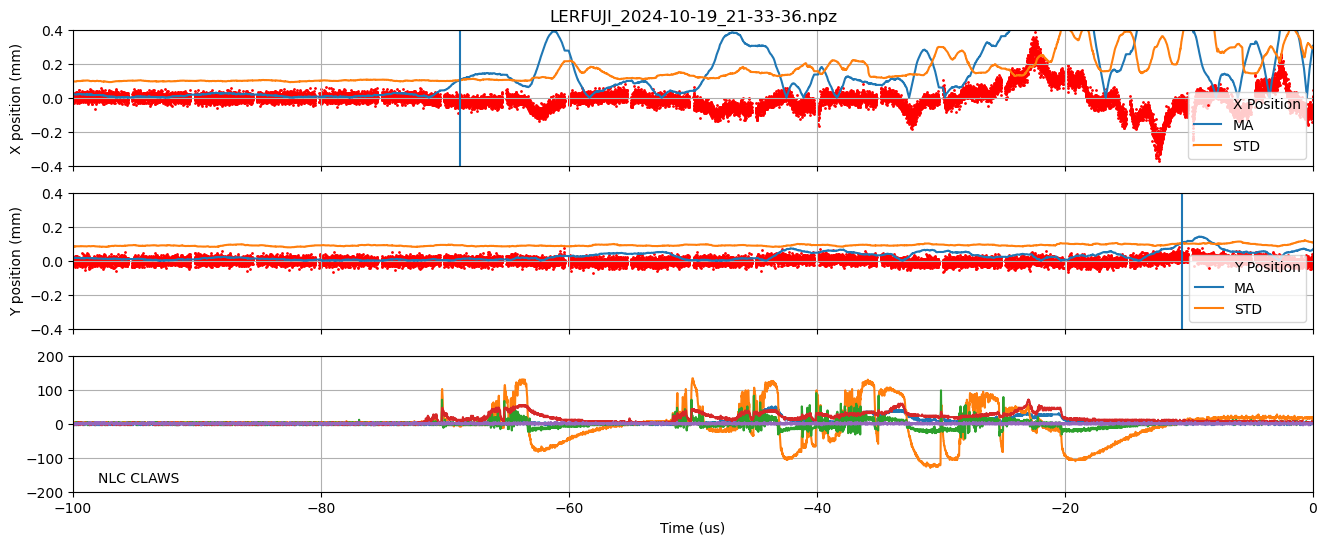

Found matching file: 20241027_050104449430.root


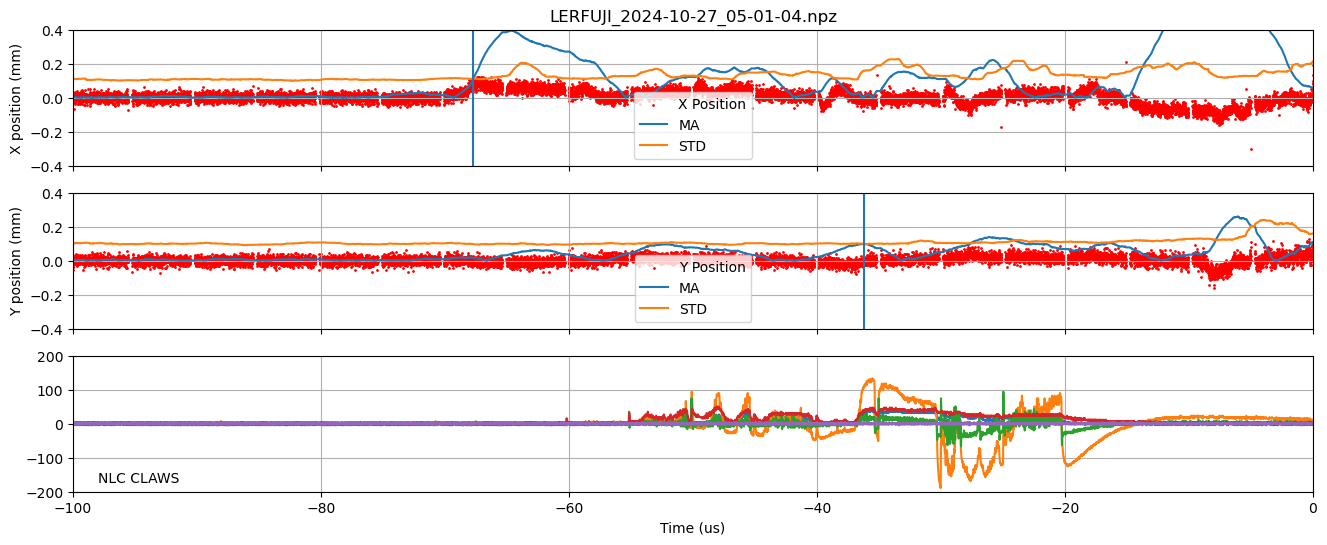

Found matching file: 20241022_093716492976.root


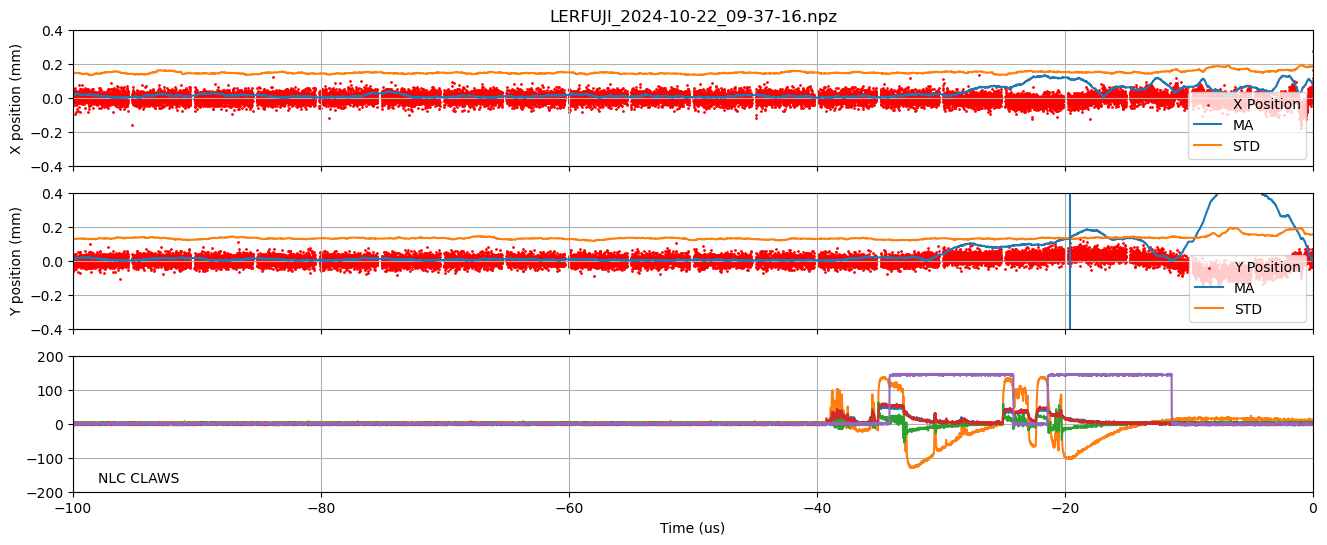

Found matching file: 20241027_212833002114.root


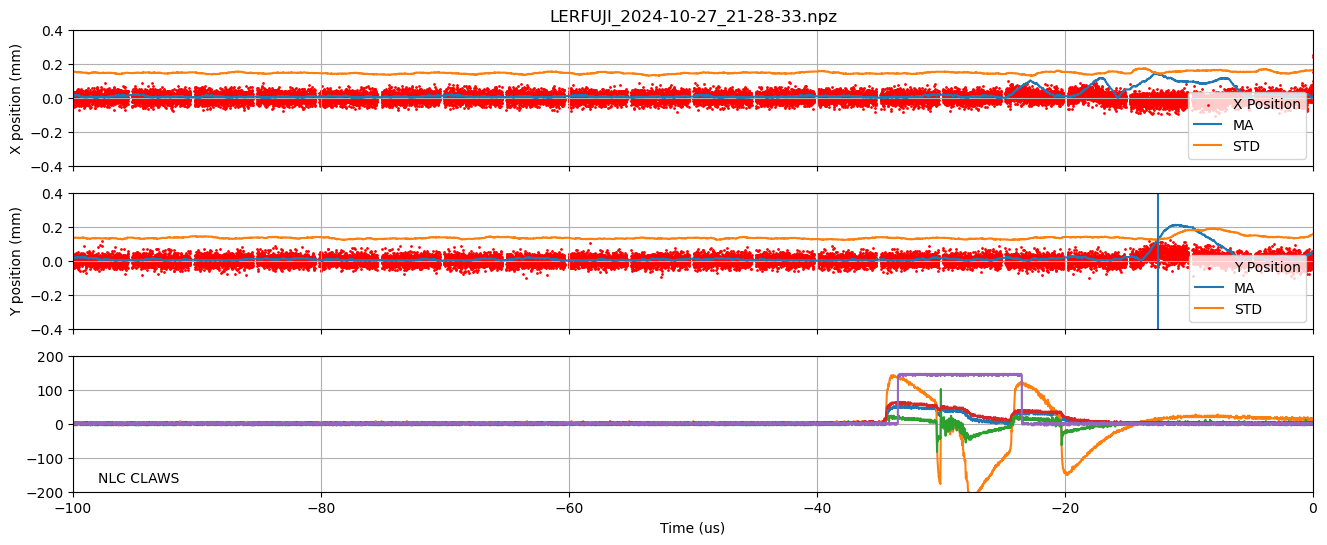

Found matching file: 20241015_200425773937.root


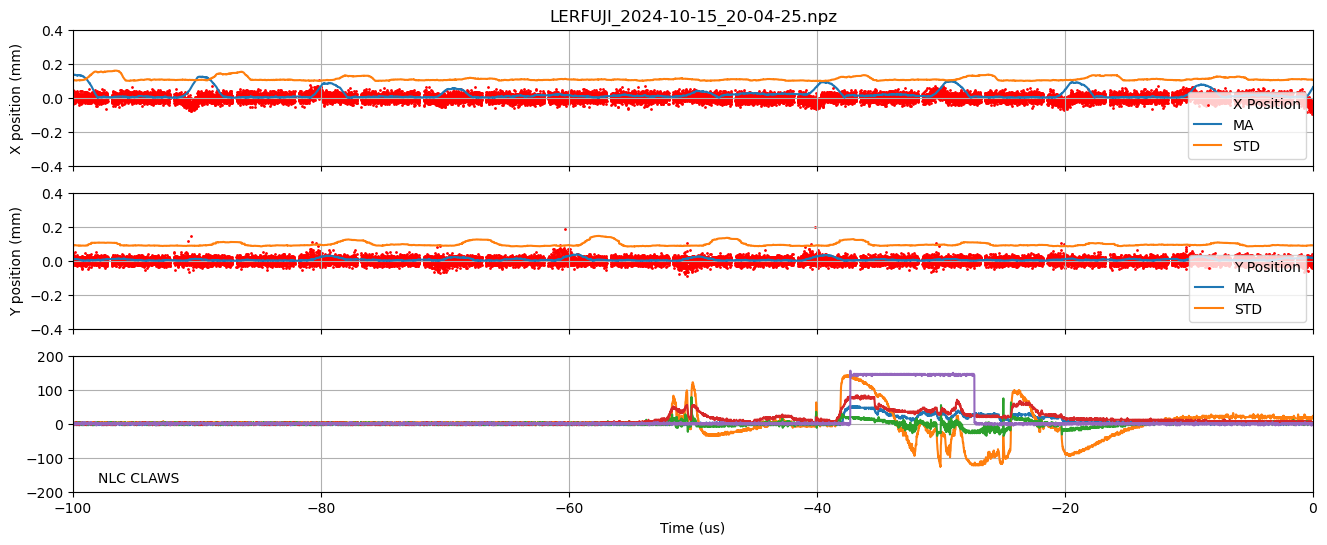

Found matching file: 20241029_014114074682.root


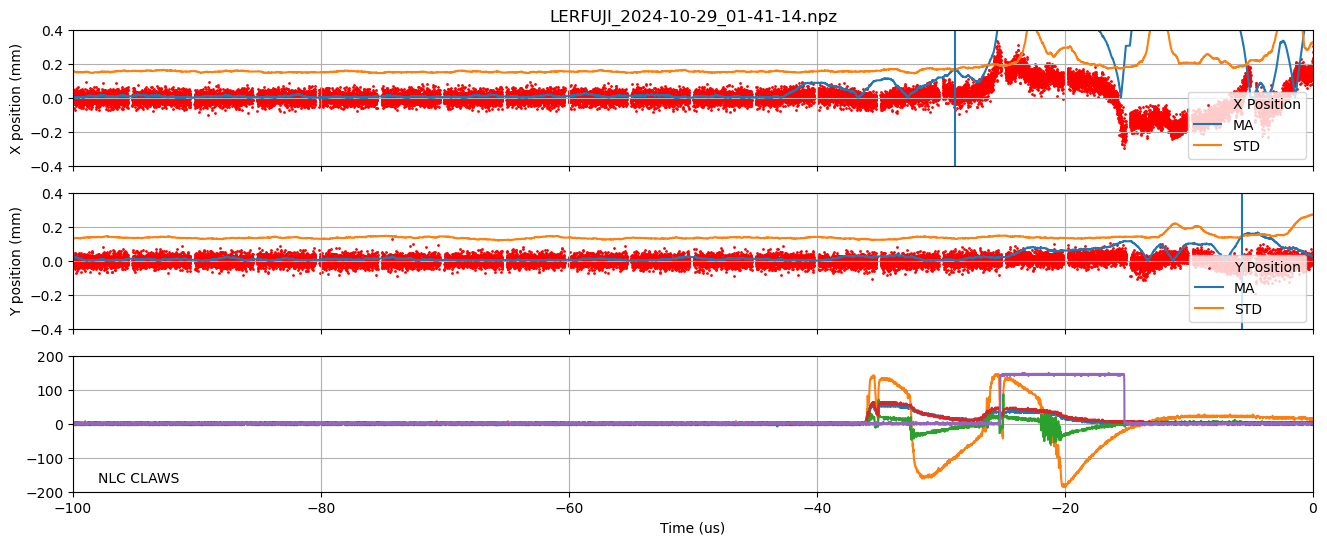

Found matching file: 20241029_030030627391.root


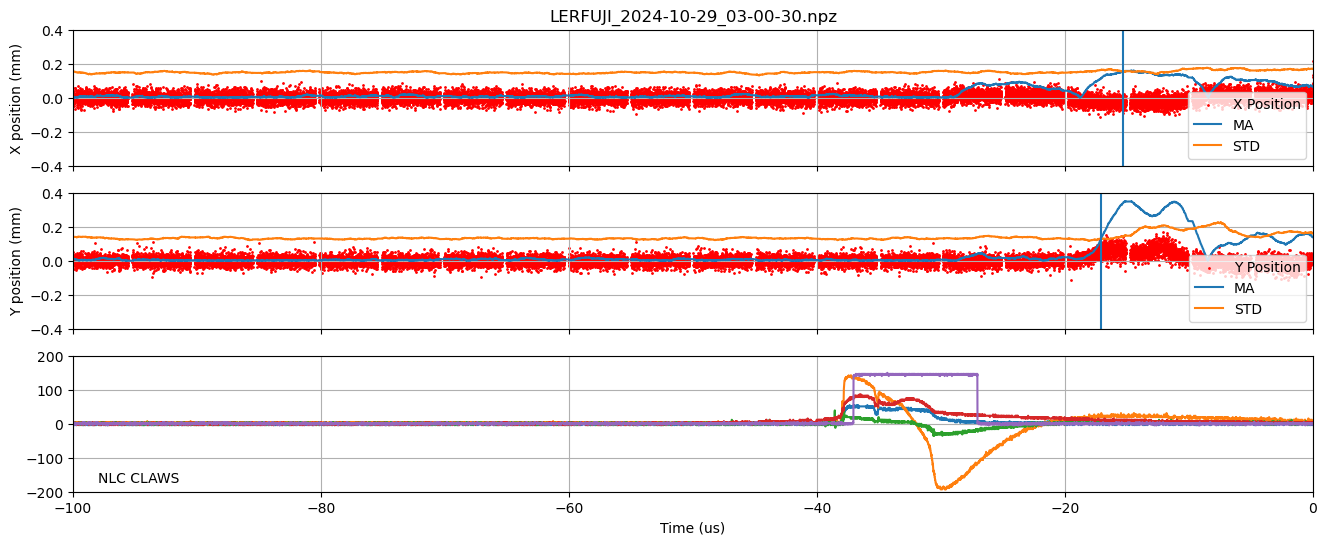

Found matching file: 20241019_180555426674.root


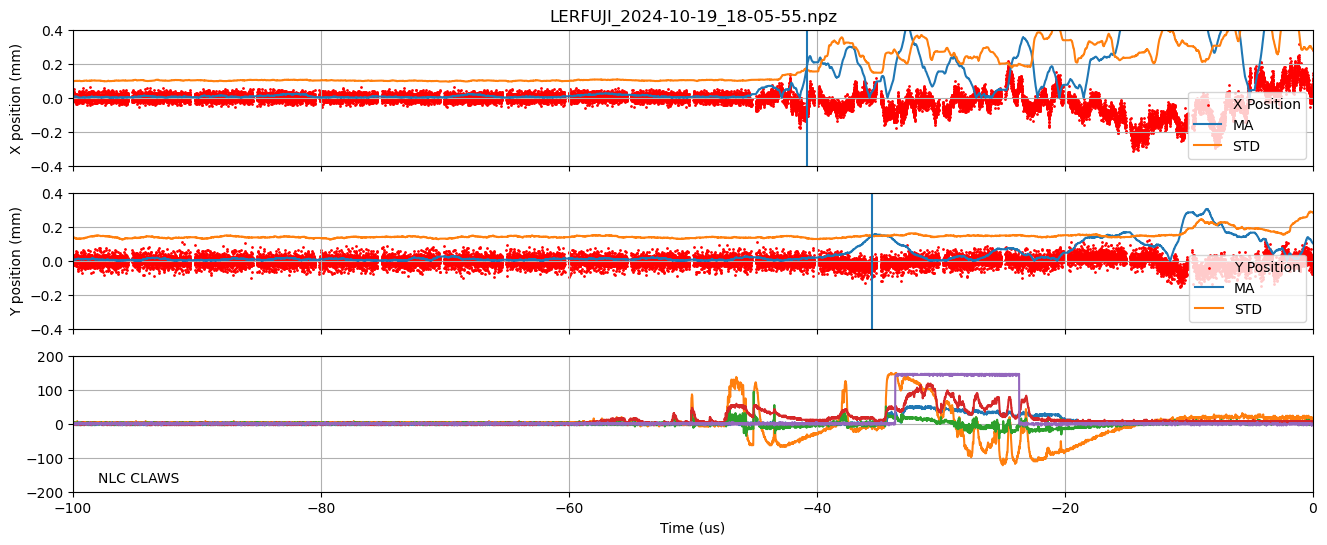

Found matching file: 20241029_194912851648.root


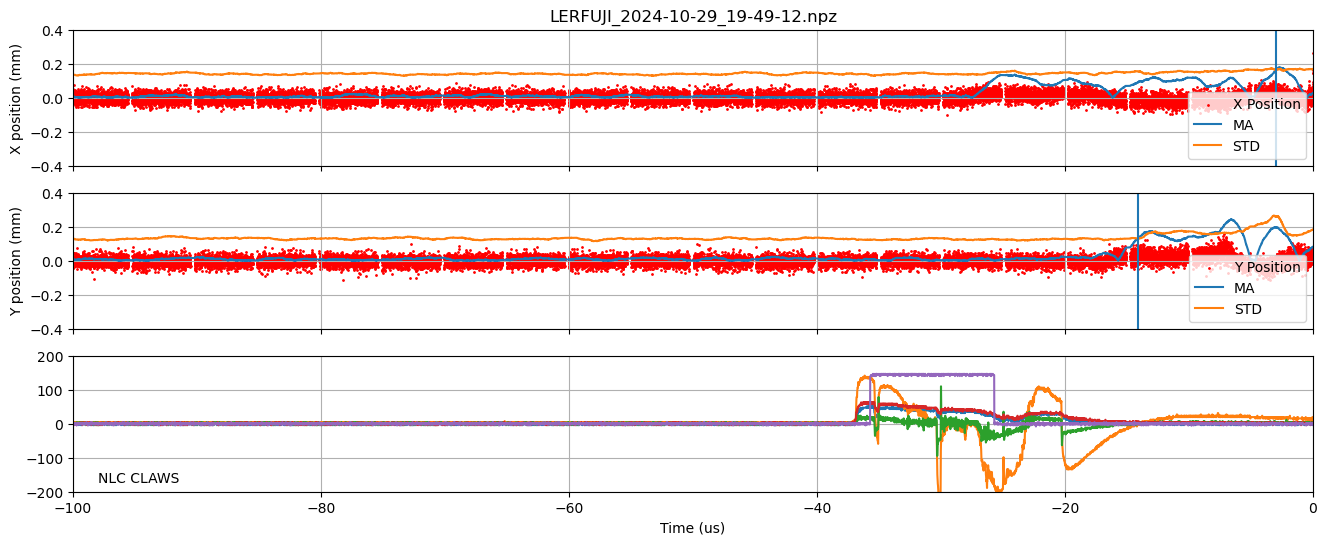

Found matching file: 20241020_211456448346.root


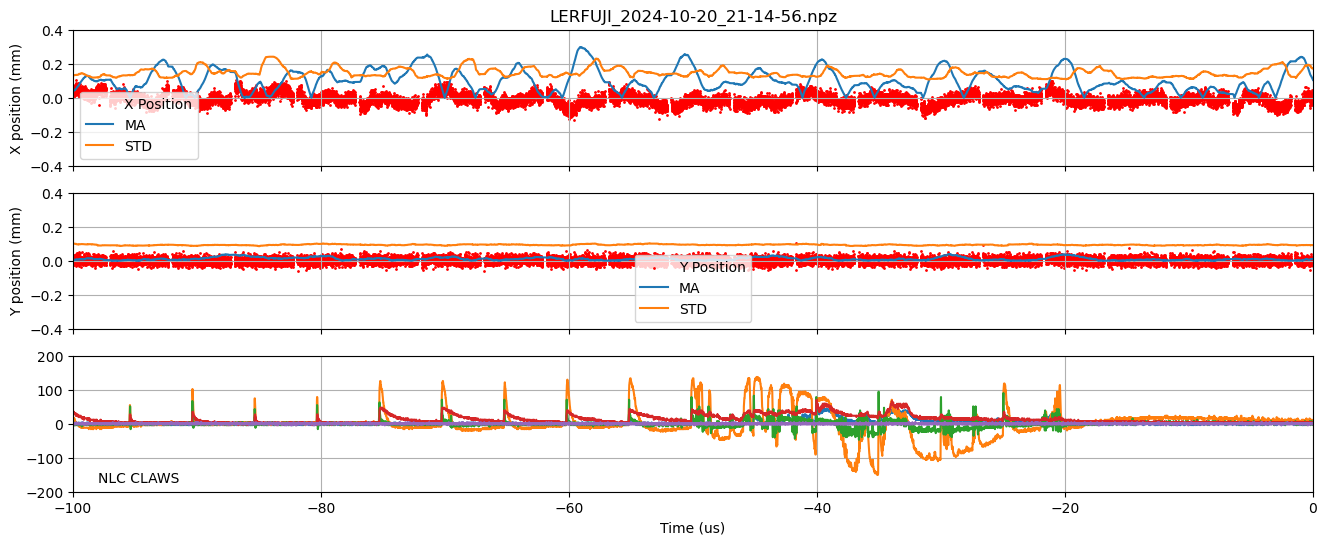

Found matching file: 20241027_134355678741.root


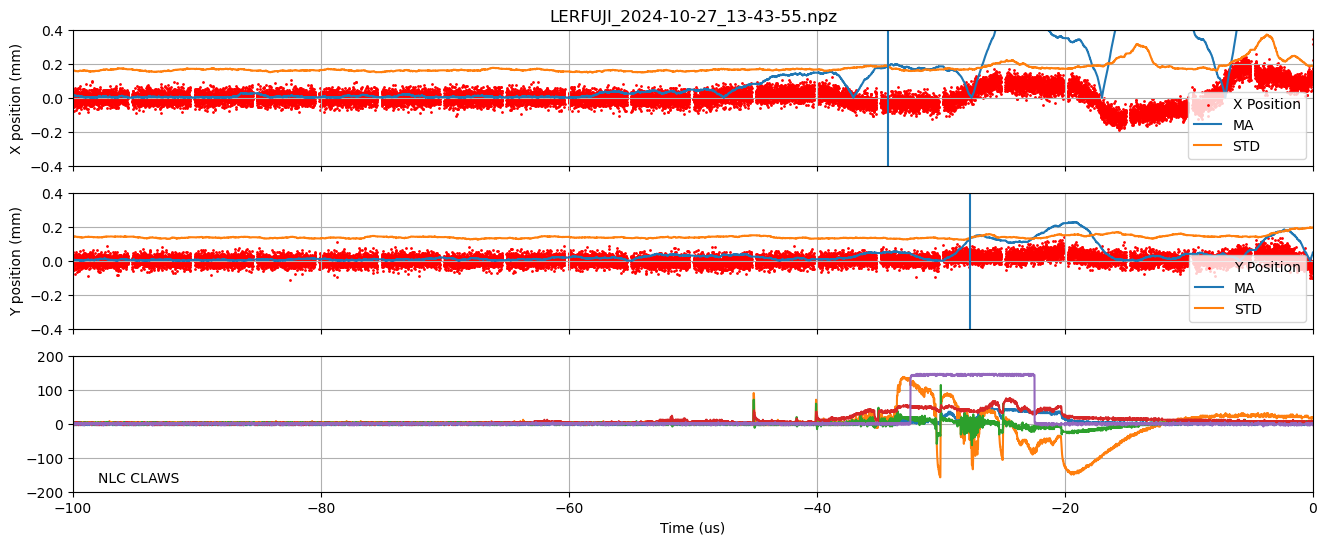

Found matching file: 20241027_065520435209.root


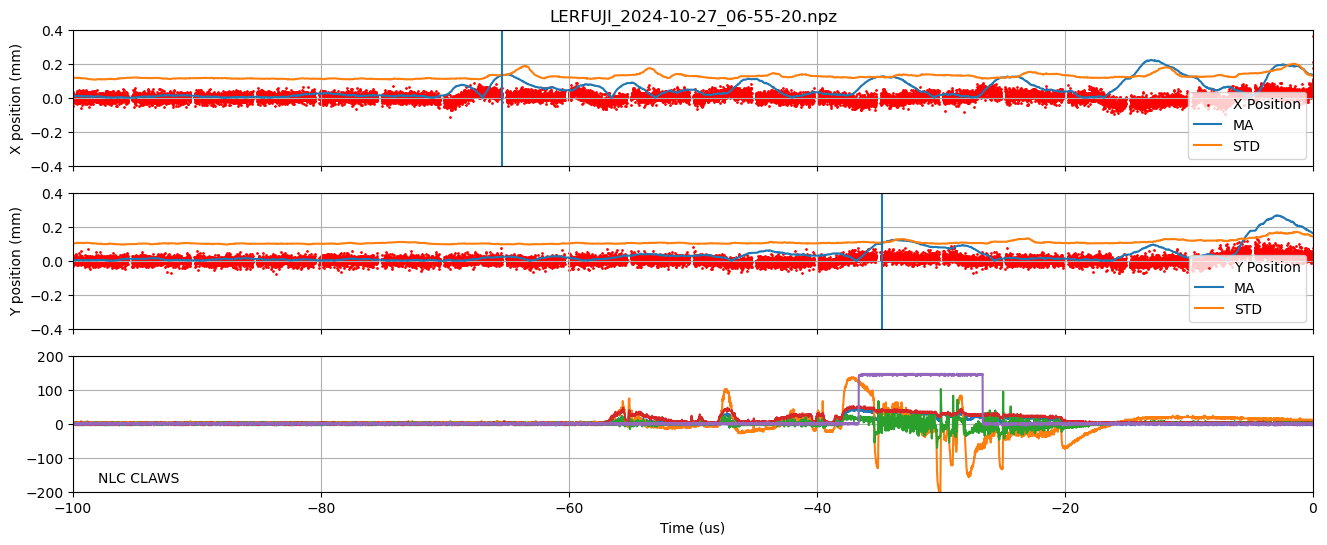

In [48]:
abort_x=[]
abort_y=[]
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/'):
    a,b=make_plot(i)
    abort_x.append(a)
    abort_y.append(b)

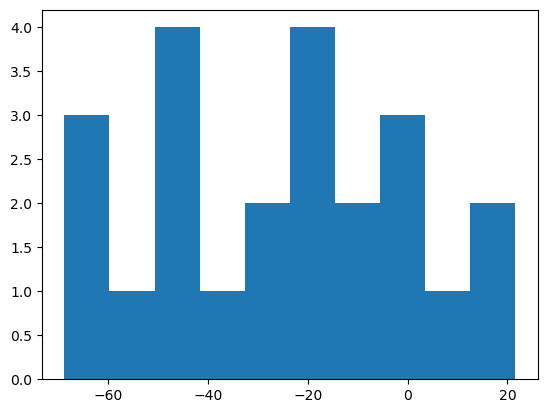

In [58]:
abort_x=np.array(abort_x)
abort_y=np.array(abort_y)
result=np.minimum(abort_x,abort_y)
plt.hist(result[result>-200],bins=10)
plt.show()